In [1]:
%matplotlib inline
# plot the molecule in 3D in an interactive window
# %matplotlib widget
%config InlineBackend.figure_format = 'retina'

In [2]:
# get current working directory
import os, sys
pwd = os.getcwd()
# append ../src/ to the sys path to access the coarsegrainer package
sys.path.append(pwd + '/../src/')

In [3]:
pwd

'/home/nima/__work/Coarse_graining/coarse_graining_code_2024_02/experiments'

In [4]:
import time
# import collections

import numpy as np
import pandas as pd

import torch
# import torch.nn.functional as F

import matplotlib.pyplot as plt

### import the coarse-graining module
import coarsegrainer as cg
# from coarsegrainer.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch
# from coarsegrainer.experimental.minimizer import EnergyMinimizerPytorch, CGMinimizerPytorch, GNNMinimizerPytorch
# from coarsegrainer.experimental.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.minimizer import EnergyMinimizer, CGMinimizer, GNNMinimizer
from coarsegrainer.energy import Energy, LJ_potential, quadratic_potential 
from coarsegrainer.plotting import plot_line_3D, plot_graph

from experimentlogger import ExperimentLogger

V = lambda x: x.detach().cpu().numpy()

## Quadratic Bonds + LJ loop
Define an energy function which uses a quadratic potential for bonds and LJ for forming a loop. 
It consists of:
1. a strong backbone line graph LJ, where every node is attracted to the next
2. a weaker loop LJ, where every l-th pair of nodes are attracted 

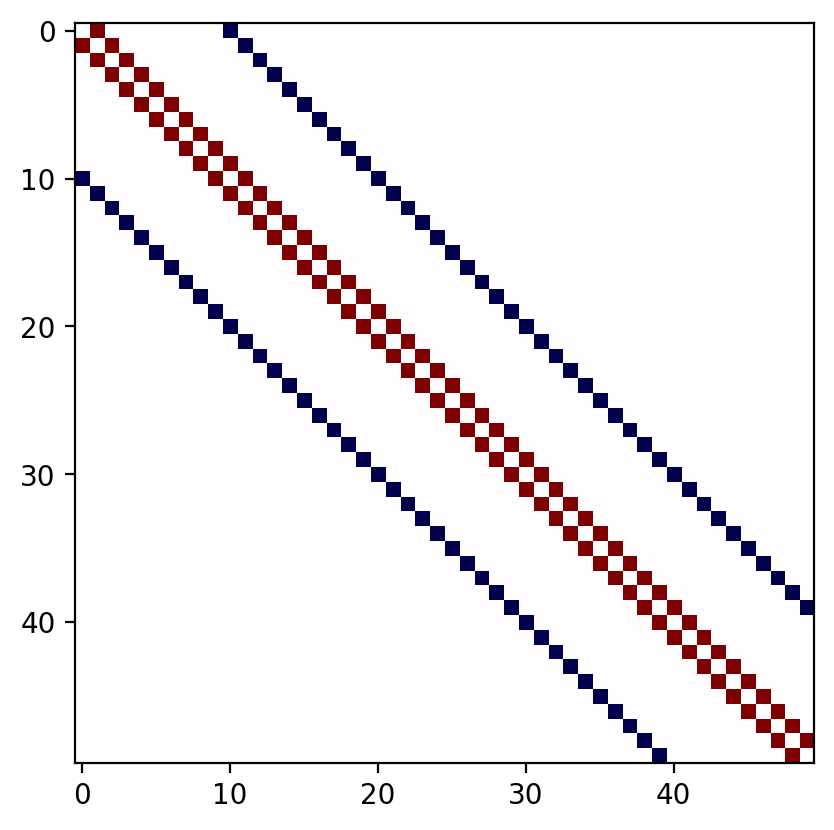

In [5]:
num_nodes, dims = 400, 3

n,d = num_nodes, dims
loop = 10
a = 1e-1

# init_sigma = 3.0 # initial standard deviation of the coordinates
# an initial std of 
init_sigma = n**(1/3)/2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

A = cg.utils.line_graph_A(n, k=1).to(device)
vdw = cg.utils.line_graph_A(n, k=loop).to(device)

A_loop = A+a*vdw

x = init_sigma*torch.randn(n, d).to(device) 

plt.imshow(V(A-vdw)[:50,:50], cmap='seismic', vmin=-1, vmax=1)

In [6]:
energy_params = dict(radius = 1, thres_A = 1e-4, lj_pow = 6, repel_pow = 1, repel_mag = 2.5e-3, 
                device = 'cuda')

energy_lj = Energy([A_loop], [LJ_potential],log_name='Energy_LJ_2scale', **energy_params)
# energy_bond_lj = Energy([A, .1*vdw], [quadratic_potential, LJ_potential],log_name='Energy_Bond_LJ', **energy_params)

In [7]:
# energy_bond_lj(x).item(), 
energy_lj(x).item()

0.21371832489967346

## Training

In [8]:
# early stopping criteria
PATIENCE = 20
MIN_DELTA = 1e-6

# learning rate
LR = 2e-2

In [9]:
# exp_logger = ExperimentLogger(previous_results_csv='../results/CG_experiment_2024-02-09-01.csv')
exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
test_logger = ExperimentLogger(save_prefix='../results/test')

In [10]:
# df = exp_logger.df

# import seaborn as sns
# # plot the filtered dataframe using sns directly on df
# sns.relplot(data=df, x='time', y='energy', hue='model_name', style='model_name', kind='scatter', size='min_delta', height=6, aspect=1.7)

# # plt.ylim(-.0247, -.0238)
# # plt.xlim(7,30)
# plt.xscale('log')
# plt.grid()

## LJ only

In [11]:
# example of using the EnergyMinimizerPytorch class
# define the initial position
# initial_pos = x = init_sigma*1*torch.randn(n, d).to(device) /2

initial_pos = x = init_sigma*torch.randn(n, d).to(device) /3
# instantiate the EnergyMinimizerPytorch class
# energy_minimizer = EnergyMinimizerPytorch(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-2, clamp_grads=.1, log_step=20, log_pos_step=0, 
#                             log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)
energy_minimizer = EnergyMinimizer(energy_lj, initial_pos, optimizer_type='Adam', lr=1e-3, clamp_grads=.01, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name='LJ_loop', patience=PATIENCE*1, min_delta=MIN_DELTA*1e-0)

Using Adam optimizer
Log name: LJ_loop
Logging to: ../results/logs/LJ_loop_n400_d3


In [12]:
energy_minimizer.logger

In [13]:
exp_logger.run_experiment(energy_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment LJ_loop_n400_d3
250 0.0295, 3.77
500 0.024, 7.47
750 0.0227, 11.07
1000 0.0225, 14.66
1250 0.0217, 18.26
1500 0.0217, 21.86
1750 0.0213, 25.45
2000 0.0213, 29.08
2250 0.0213, 32.66
Early stopping at step 4900
2496 0.0213, 36.18


Text(0.5, 1.0, 'Energy vs time (min E: 0.0213, t=36.18 s)')

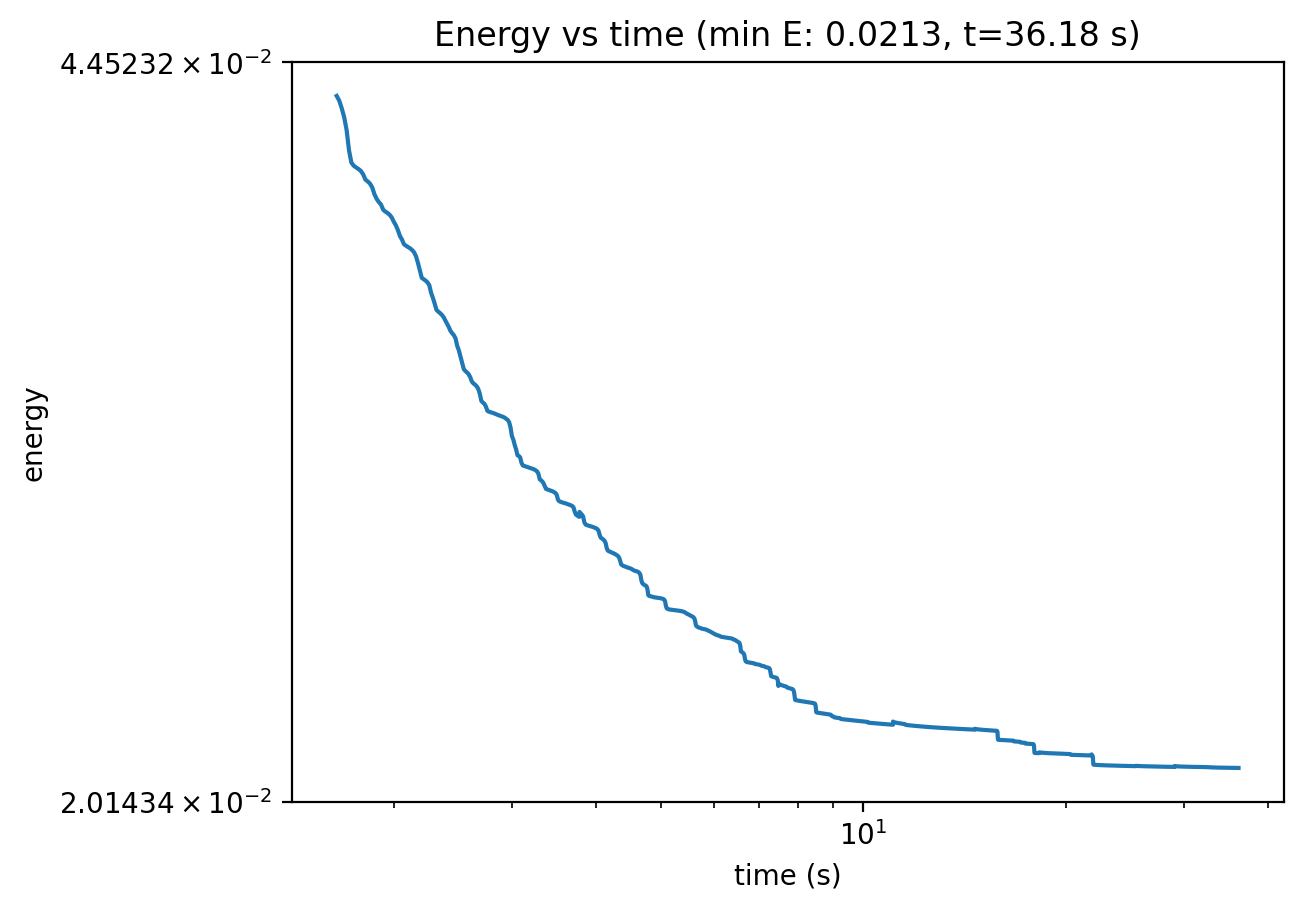

In [14]:
energy_minimizer.plot_history(start=100)
h = energy_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [15]:
exp_logger.df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std
0,Energy_LJ_2scale,LJ_loop_n400_d3,0.021252,36.181808,0.001,0.01,20,0.000001,1.208279


In [16]:
energy_minimizer.get_x().std(), init_sigma

(tensor(4.9936, device='cuda:0', grad_fn=<StdBackward0>), 3.6840314986403864)

In [17]:
r = 2.5e-1
# v = plot_graph_3D(V(energy_minimizer.get_x()), A,  node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='blue', edge_color='blue')
v = plot_line_3D(V(energy_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')
# Capture the current view as a PNG image
# v.png()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [19]:
# exp_logger = ExperimentLogger(previous_results_csv='../results/CG_experiment_2024-02-09-01.csv')
exp_logger = ExperimentLogger(save_prefix='../results/CG_Bond_LJ_experiment') 
test_logger = ExperimentLogger(save_prefix='../results/test')

In [15]:
h = energy_minimizer.train(5000)

Early stopping at step 4080


In [14]:
exp_logger.df

,energy_function,model_name,energy,time,lr,clamp_grads,patience,min_delta,x0_std
0,Energy_LJ_2scale,LJ_loop_n400_d3,-0.006895,35.318704,0.001,0.01,20,0.000001,1.292495


In [15]:
energy_minimizer.get_x().std(), init_sigma

(tensor(5.5694, device='cuda:0', grad_fn=<StdBackward0>), 3.6840314986403864)

### CG Using multiple samples

In [11]:
init_sigma

3.6840314986403864

In [18]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 40
# produce k samples with different std for x
x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-2, 2e-1, k)[:, None, None].to(device)
# x_samples = init_sigma*torch.randn(k, n, d, device =device)*torch.linspace(1e-1, 2e-0, k)[:, None, None].to(device)
cg_bond_lj = cg.CG.CoarseGrainer(energy_lj, num_cg_modes=120)
cg_bond_lj.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.32 seconds
spectrum of the Laplacian computed in 0.04 seconds


0.39252543449401855

In [19]:
init_sigma/16, 1/(2*d)

(0.23025196866502415, 0.16666666666666666)

In [20]:
A.shape, x.shape

(torch.Size([400, 400]), torch.Size([400, 3]))

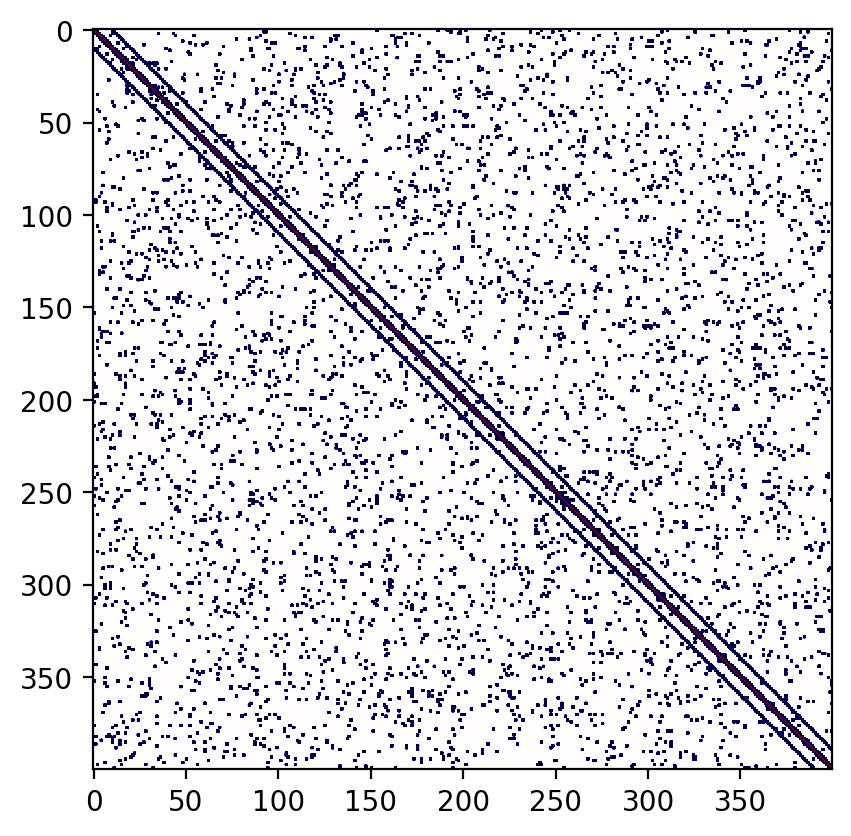

In [21]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


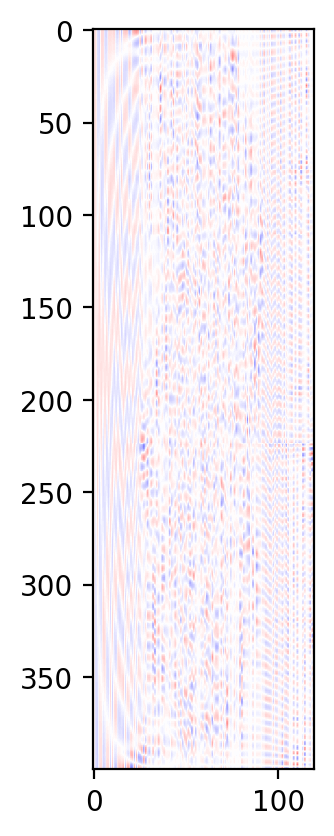

In [22]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [23]:
# cg_minimizer.start_fine_graining()
# cg_minimizer.early_stopping_triggered = False
# h = cg_minimizer.train(20000)

### Multi-stage CG
gradually increase the number cg modes used

In [24]:
cg_min_params = dict(optimizer_type='Adam', lr=LR, lr_cg=1e-1,
            clamp_grads=.01, log_step=20, log_pos_step=0, 
            log_dir='../results/logs', log_name='CG_LJ_loop', 
            patience=PATIENCE, min_delta=MIN_DELTA*1e-2,
            cg_patience=PATIENCE, cg_min_delta=MIN_DELTA*1e-2)

In [25]:
num_cg_modes = n//4
initial_pos = x = init_sigma*torch.randn(n, d).to(device)/4 # 3
# instantiate the CGMinimizerPytorch class
cg_minimizer = CGMinimizer(energy_lj, initial_pos, cg_bond_lj.cg_modes[:,:num_cg_modes], **cg_min_params)

Using Adam optimizer
Log name: CG_LJ_loop
Logging to: ../results/logs/CG_LJ_loop_n400_d3
Using Adam optimizer


In [26]:
initial_pos.std()

tensor(0.9358, device='cuda:0')

In [27]:
exp_logger.run_experiment(cg_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment CG_LJ_loop_n400_d3
250 0.442, 4.21
500 0.437, 8.15
Early stopping at step 3760
Starting fine-graining
939 0.406, 14.88
1189 0.405, 18.65
1439 0.404, 22.41
1689 0.404, 26.15
1939 0.403, 29.91
Early stopping at step 2480
2064 0.403, 31.81


In [28]:
for i in range(10):
    h= cg_minimizer.train(20000)

Early stopping at step 2800
Early stopping at step 2280
Early stopping at step 3540
Early stopping at step 940
Early stopping at step 8600
Early stopping at step 1340
Early stopping at step 2860
Early stopping at step 1080
Early stopping at step 4320
Early stopping at step 1900


In [29]:
cg_minimizer.cg_steps

689

Text(0.5, 1.0, 'Energy vs time (min E: 0.402, t=54.74 s)')

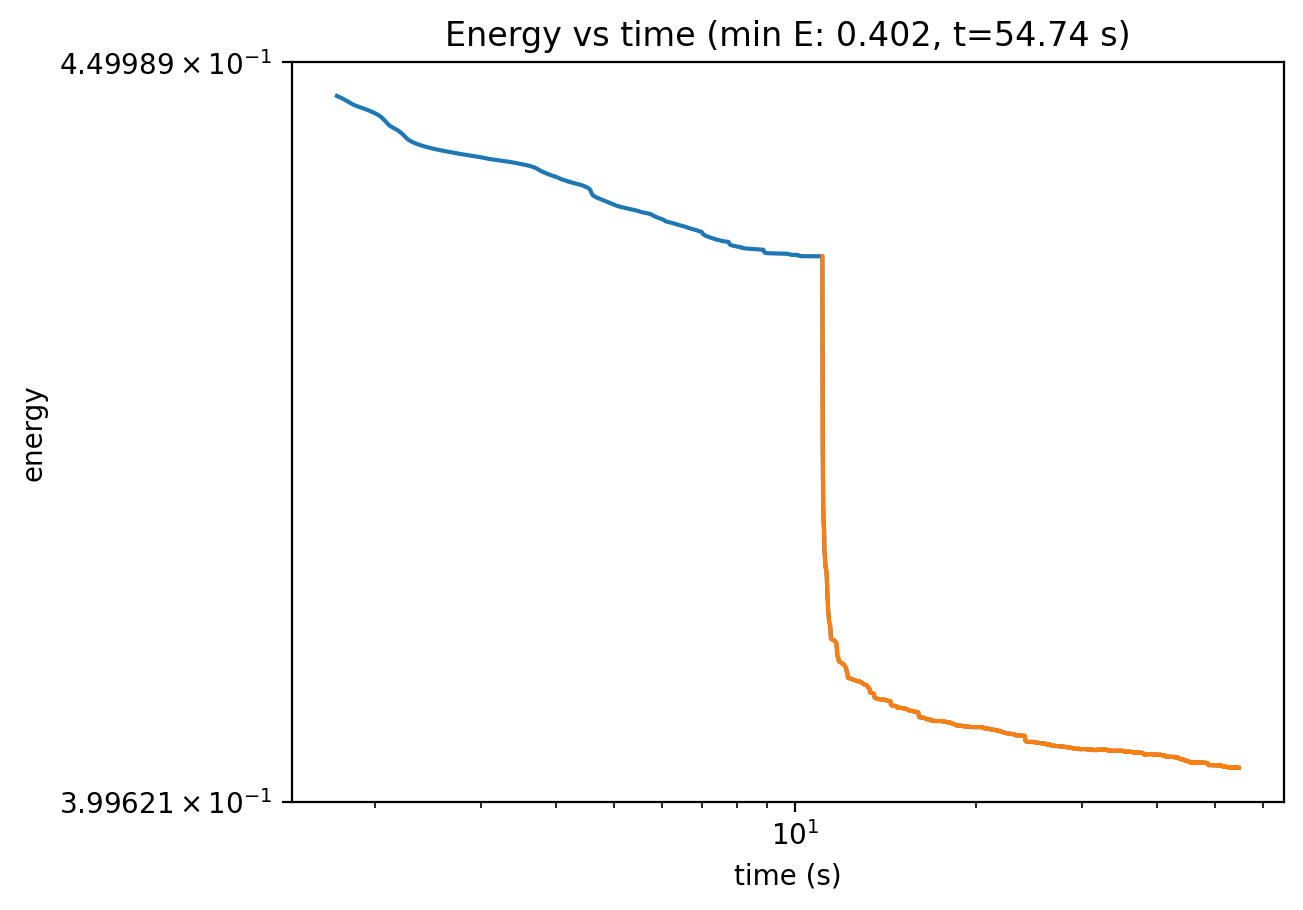

In [30]:
cg_minimizer.plot_history(start=100)
cg_minimizer.plot_history(start=cg_minimizer.cg_steps+0)
h = cg_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [31]:
cg_minimizer.fine_grained

True

In [32]:
r = 5e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(cg_minimizer.get_x()), A, r = 5e-1, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [44]:
# h = cg_minimizer.train_one_stage(20000)

In [ ]:
cg_minimizer.history.keys()

dict_keys(['time', 'energy', 'x'])

In [33]:
t0 = time.time()
# x_samples = init_sigma/2*torch.randn(4*n, n, d, device =device)
# note: large init_sigma resulted in diverging hessian
# x_samples = init_sigma*1*torch.randn(4*n, n, d, device =device)
k = 10
# produce k samples with different std for x

x0 = cg_minimizer.get_x().detach().clone()
s = x0.std().item()

x_samples = s/10*torch.randn(k, n, d, device = device)*torch.linspace(2e-1, 1e0, k)[:, None, None].to(device)
x_samples = x_samples + x0

cg_bond_lj = cg.CG.CoarseGrainer(energy_lj, num_cg_modes=120)
cg_bond_lj.get_cg_modes(x_samples)
cg_time = time.time() - t0
cg_time

force constant matrix computed in 0.07 seconds
spectrum of the Laplacian computed in 0.01 seconds


0.08513402938842773

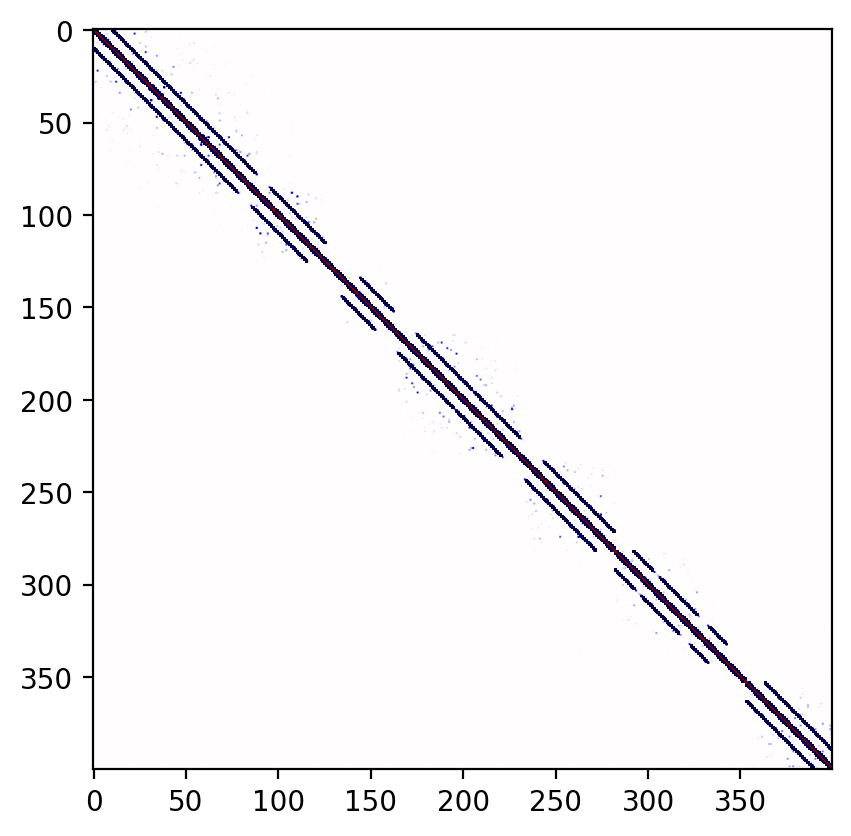

In [34]:
b = 1e-3
plt.imshow(np.arcsinh(1e3*V(cg_bond_lj.L)), cmap='seismic', vmin=-b, vmax=b)


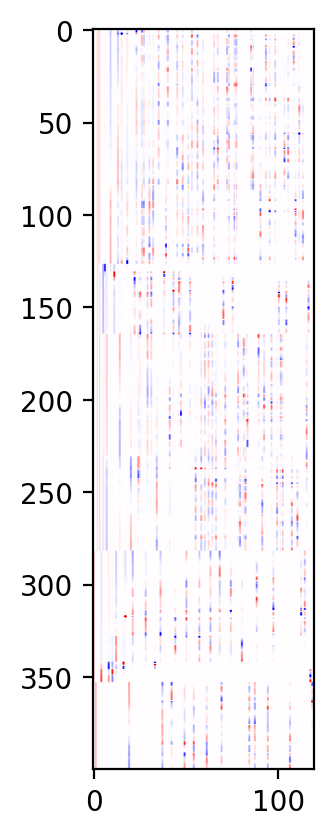

In [35]:
c = V(cg_bond_lj.cg_modes)
plt.imshow(c, cmap='seismic', vmin=-1, vmax=1) 

In [36]:
x.std()

tensor(0.9358, device='cuda:0')

## GNN

In [37]:
from coarsegrainer.GNN import GNNReparam
# example of using the GNNMinimizerPytorch class
# define the initial position
initial_pos = x = init_sigma*torch.randn(n, d).to(device)/4
print(f"Initial std of x: {x.std().item():.3g}")

# example of using the GNNReparam class
h=20
num_cg_modes = n//3

n = len(A)
# similar to xavier initialization, we can set latent_sigma to 1/sqrt(h)
gnn_reparam = GNNReparam([h, h//2, d], cg_bond_lj, num_cg=num_cg_modes, # latent_sigma=1/np.sqrt(h), 
                        bias=True, activation=torch.nn.Tanh(), output_init_sigma= x.std().item())#.to(device)
# print(f"std before rescaling {gnn_reparam().std().item():.3g}")
# gnn_reparam.rescale_output(x.std().item())

# since std of x is init_sigma, std of gnn_reparam should be init_sigma
# but because of the gnn, it is not
# we can use the last linear layer to scale the output to match x
# we can use the std of the last layer to scale the output
# we will rescale the parameters of the last layer to match the std of x

# init_gnn_std = gnn_reparam().std()
# # rescale the weights of the last layer by the ratio of the stds
# # gnn_reparam.gnn.layers[-1].weight.data *= init_sigma/init_gnn_std*1.

# gnn_reparam.gnn.layers[-1].weight.data *= x.std().item()/init_gnn_std*1.
print(f"std after rescaling {gnn_reparam().std().item():.3g}")

# instantiate the GNNMinimizerPytorch class
# gnn_minimizer = GNNMinimizerPytorch(
gnn_minimizer = GNNMinimizer(
    energy_lj, 1*initial_pos, gnn_reparam, optimizer_type='Adam', 
                            lr=1*LR, lr_gnn=2e-3,
                            # lr=2*LR, lr_gnn=4e-3,
                            clamp_grads=1e-2, log_step=20, log_pos_step=0, 
                            log_dir='../results/logs', log_name=f'GNN_Bond_LJ{num_cg_modes/n:.2f}',
                            patience=PATIENCE, min_delta=MIN_DELTA*1e-1, 
                            gnn_patience=PATIENCE, gnn_min_delta=MIN_DELTA*1e-1)


Initial std of x: 0.944
std after rescaling 0.876
Using Adam optimizer
Log name: GNN_Bond_LJ0.33
Logging to: ../results/logs/GNN_Bond_LJ0.33_n400_d3
Using Adam optimizer


In [38]:
gnn_minimizer.energy_func(x), gnn_minimizer.energy_func(gnn_minimizer.get_x())

(tensor(1.9036, device='cuda:0'),
 tensor(2.6457, device='cuda:0', grad_fn=<AddBackward0>))

In [39]:
# gnn_minimizer.min_delta *= 1e-1

In [40]:
# for i in range(20):
#     gnn_minimizer.early_stop.reset()
#     h= super(GNNMinimizer, gnn_minimizer).train(20000, update_pairs=True)

In [41]:
exp_logger.run_experiment(gnn_minimizer, epochs=10, steps=5000, x0_std=initial_pos.std().item())

Running experiment GNN_Bond_LJ0.33_n400_d3
250 0.728, 5.15
500 0.727, 10.34
Early stopping at step 2840
Starting fine-graining
893 0.727, 16.98
Early stopping at step 3420
1065 0.727, 19.59


In [42]:
for i in range(10):
    h= gnn_minimizer.train(20000)

Early stopping at step 4840
Early stopping at step 3060
Early stopping at step 3780
Early stopping at step 2620
Early stopping at step 1880
Early stopping at step 2000
Early stopping at step 1200
Early stopping at step 1080
Early stopping at step 1400
Early stopping at step 1000


In [44]:
gnn_minimizer.early_stop.min_delta

1e-07

Text(0.5, 1.0, 'Energy vs time (min E: 0.981, t=23.57 s)')

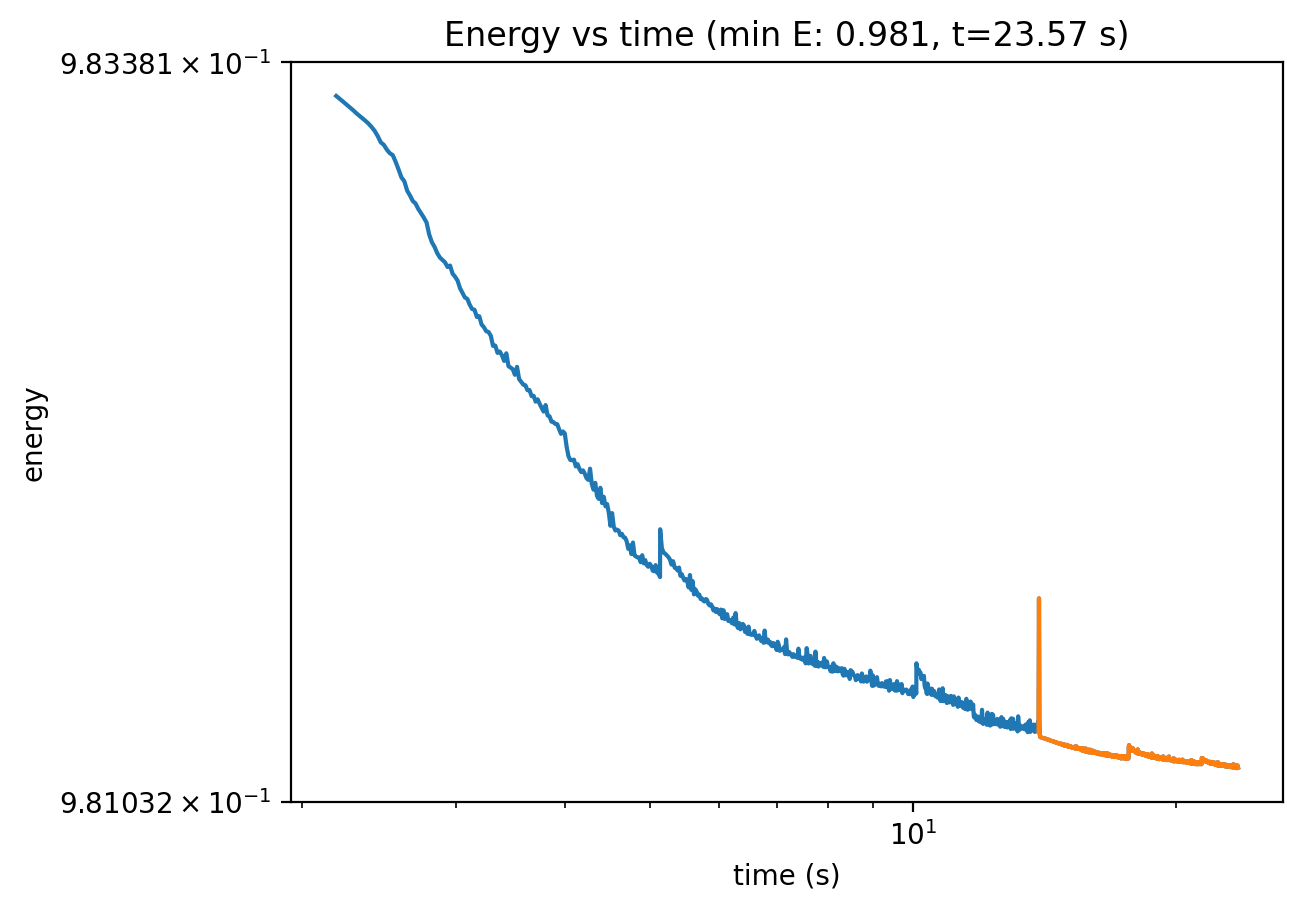

In [38]:
gnn_minimizer.plot_history(start=100)
gnn_minimizer.plot_history(start=gnn_minimizer.gnn_steps)
h = gnn_minimizer.history
plt.title(f'Energy vs time (min E: {min(h["energy"]):.3g}, t={np.sum(h["time"]):.2f} s)')


In [39]:
gnn_minimizer.min_delta, gnn_minimizer.early_stop.min_delta

(1e-07, 1e-07)

In [40]:
gnn_minimizer.early_stop.early_stopping_triggered

True

In [41]:
r = 3e-1
# v = plot_graph_3D(V(cg_minimizer.get_x()), A, node_radius=r/2, edge_thickness=r, eps=1e-4, node_color='red', edge_color='red')
v = plot_line_3D(V(gnn_minimizer.get_x()), A, r = r, eps=1e-4, colormap='jet')

# Capture the current view as a PNG image
# v.png()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.